In [80]:
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

font = {"family": "YuGothic"}
matplotlib.rc("font", **font)

In [81]:
client60_single = pd.read_csv("../log-single-client60/nginx-minis2.csv")
client60_single = client60_single.select_dtypes(include=["int", "float"])
client60_single_h2_start = client60_single["Time"].min() + 30
client60_single_h2_end = 1675605220 - 30
client60_single_h3_start = 1675605833 + 30
client60_single_h3_end = client60_single["Time"].max() - 30
print(
    client60_single_h2_end - client60_single_h2_start,
    client60_single_h3_end - client60_single_h3_start,
)
client60_single.dtypes


1894 2266


Time         int64
UID          int64
PID          int64
%usr       float64
%system    float64
%guest     float64
%wait      float64
%CPU       float64
CPU          int64
dtype: object

In [82]:
client60_simple = pd.read_csv("../log-simple-client60/nginx-minis2.csv")
client60_simple = client60_simple.select_dtypes(include=["int", "float"])
client60_simple_h2_start = client60_simple["Time"].min() + 30
client60_simple_h2_end = 1675601408 - 30
client60_simple_h3_start = 1675602012 + 30
client60_simple_h3_end = client60_simple["Time"].max() - 30
print(
    client60_simple_h2_end - client60_simple_h2_start,
    client60_simple_h3_end - client60_simple_h3_start,
)
client60_simple.dtypes


284 290


Time         int64
UID          int64
PID          int64
%usr       float64
%system    float64
%guest     float64
%wait      float64
%CPU       float64
CPU          int64
dtype: object

In [83]:
def cpu_performance(df: pd.DataFrame, start: int, end: int):
    df_groupby = df[(start <= df["Time"]) & (df["Time"] <= end)].groupby("Time")
    df_groupby = df_groupby.sum()
    return df_groupby


In [84]:
client60_single_h2 = cpu_performance(client60_single, client60_single_h2_start, client60_single_h2_end)
des_single_h2 = client60_single_h2[[r"%usr", r"%system", r"%CPU"]].describe()
des_single_h2.to_csv("server-single-h2.csv")
client60_single_h3 = cpu_performance(client60_single, client60_single_h3_start, client60_single_h3_end)
des_single_h3 = client60_single_h3[[r"%usr", r"%system", r"%CPU"]].describe()
des_single_h3.to_csv("server-single-h3.csv")
result_single = pd.DataFrame()
result_single["HTTP/2\n/single.html"] = client60_single_h2[r"%CPU"].reset_index(drop=True)
result_single["HTTP/3\n/single.html"] = client60_single_h3[r"%CPU"].reset_index(drop=True)
result_single.to_csv("server-describe.csv", index=False)
result_single

,HTTP/2\n/single.html,HTTP/3\n/single.html
0,10.0,61.0
1,31.0,53.0
2,8.0,59.0
3,14.0,58.0
4,18.0,68.0
...,...,...
1890,11.0,58.0
1891,13.0,54.0
1892,22.0,60.0
1893,17.0,55.0


In [85]:
client60_simple_h2 = cpu_performance(client60_simple, client60_simple_h2_start, client60_simple_h2_end)
des_simple_h2 = client60_simple_h2[[r"%usr", r"%system", r"%CPU"]].describe()
des_simple_h2.to_csv("server-simple-h2.csv")
client60_simple_h3 = cpu_performance(client60_simple, client60_simple_h3_start, client60_simple_h3_end)
des_simple_h3 = client60_simple_h3[[r"%usr", r"%system", r"%CPU"]].describe()
des_simple_h3.to_csv("server-simple-h3.csv")
result_simple = pd.DataFrame()
result_simple["HTTP/2\n/simple.html"] = client60_simple_h2[r"%CPU"].reset_index(drop=True)
result_simple["HTTP/3\n/simple.html"] = client60_simple_h3[r"%CPU"].reset_index(drop=True)
result_simple.to_csv("server-describe.csv", index=False)
result_simple


,HTTP/2\n/simple.html,HTTP/3\n/simple.html
0,34.0,36.0
1,35.0,32.0
2,34.0,35.0
3,32.0,39.0
4,31.0,37.0
...,...,...
280,31.0,39.0
281,34.0,33.0
282,32.0,33.0
283,34.0,40.0


In [86]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 6))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
result = pd.concat([result_simple, result_single], axis=1)


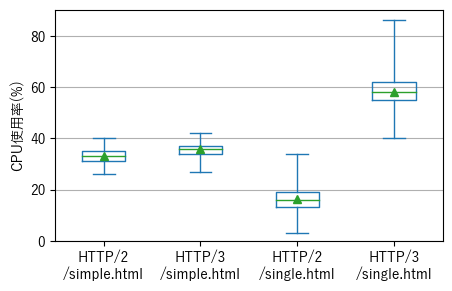

In [87]:
plot = result.plot.box(
    showmeans=True, ylabel="CPU使用率(%)", figsize=(5, 3), whis=[0, 100]
)
plot.set_ylim(0)
plot.grid(which="major", axis="y")


In [88]:
from scipy.stats import f
from scipy import stats
import numpy as np


def ftest(a, b):
    # 　統計量Fの計算
    v1 = np.var(a, ddof=1)
    v2 = np.var(b, ddof=1)
    n1 = len(a)
    n2 = len(b)
    f_value = v1 / v2

    # 帰無仮説が正しい場合にFが従う確率分を生成
    f_frozen = f.freeze(dfn=n1 - 1, dfd=n2 - 1)

    # 右側
    p1 = f_frozen.sf(f_value)
    # 左側
    p2 = f_frozen.cdf(f_value)
    # 小さい方の2倍がp値
    p_value = min(p1, p2) * 2

    # 統計量Fとp値を返す
    return f_value, p_value


def t_test(a, b):
    a = a.dropna()
    b = b.dropna()
    print(
        a.mean(),
        a.std(),
        b.mean(),
        b.std(),
    )
    f = ftest(
        a,
        b,
    )
    toubunsanse = (
        ftest(
            a,
            b,
        )[1]
        > 0.0005
    )
    print(f"{f=}")
    print(f"{toubunsanse=}")
    print(
        stats.shapiro(a)[1],
        stats.shapiro(b)[1],
    )
    print(
        stats.ttest_ind(
            a,
            b,
            equal_var=toubunsanse,
        )
    )

In [89]:
results = result


32.980210526315794 2.441118702337699 35.65014035087719 2.477410331790691
f=(0.9709165570051213, 0.8037689461642022)
toubunsanse=True
0.0018186196684837341 0.0006941667525097728
Ttest_indResult(statistic=-12.959558704452624, pvalue=7.813565174566463e-34)


<AxesSubplot: ylabel='Frequency'>

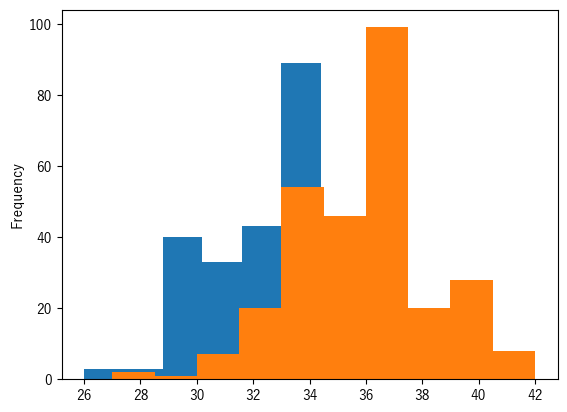

In [90]:
t_test(
    results["HTTP/2\n/simple.html"],
    results["HTTP/3\n/simple.html"],
)
results["HTTP/2\n/simple.html"].plot.hist()
results["HTTP/3\n/simple.html"].plot.hist()


16.10930870712401 4.895462890639242 58.23661213720317 5.386695999975933
f=(0.8259287659627641, 3.21289404900475e-05)
toubunsanse=False
2.763884390452609e-12 6.932284929336277e-15
Ttest_indResult(statistic=-251.94392215058608, pvalue=0.0)


<AxesSubplot: ylabel='Frequency'>

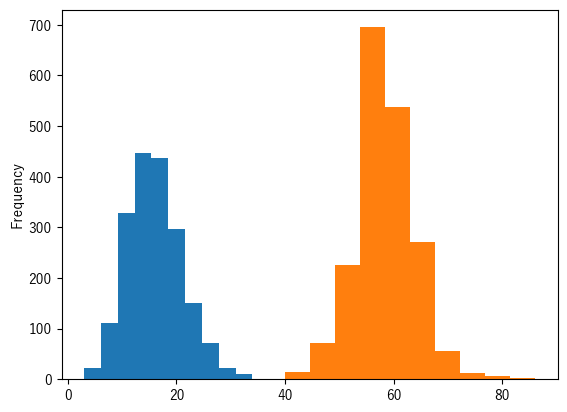

In [91]:
t_test(
    results["HTTP/2\n/single.html"],
    results["HTTP/3\n/single.html"],
)
results["HTTP/2\n/single.html"].plot.hist()
results["HTTP/3\n/single.html"].plot.hist()